In [1]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
clfile = os.path.join('..','src','glm_gpu','cl','logistic.cl')
os.path.isfile(clfile)

True

In [640]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
device = pcl.get_platforms()[0].get_devices()[2]
cntx = pcl.Context([device])
queue = pcl.CommandQueue(cntx)

with open(clfile, 'r') as f:
    programs = pcl.Program(cntx, f.read()).build()

In [641]:
device.name

'AMD Radeon R9 M370X Compute Engine'

In [642]:
theta = np.array([0.5, 0.5], dtype=np.float32)

In [643]:
theta.dtype

dtype('float32')

In [644]:
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

In [645]:
nsamps=2

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


In [646]:
X_all = pd.concat((X_1, X_0), ignore_index=True)

In [647]:
X_all = X_all.reindex(np.random.permutation(X_all.index))

In [648]:
X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [649]:
X.values

array([[ 7.45999813,  9.40224457],
       [ 4.99564314, -6.58889055],
       [ 4.78229189, -0.71666139],
       [ 8.69048786,  2.88852334]], dtype=float32)

In [650]:
cost_arr = np.zeros(shape=(X.shape[0],)).astype(np.float32)
temp_avg = np.zeros(shape=(4,)).astype(np.float32)

In [651]:
# compute cost
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)

cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
temp_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=temp_avg.nbytes)
scratch_buf = pcl.LocalMemory(np.float32().nbytes * 256)

nrows = np.int32(X.shape[0])
ncols = np.int32(X.shape[1])

out = np.zeros(shape=(X.shape[0],), dtype=np.float32)
out_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=out.nbytes)

In [652]:
sig_event = programs.sig(queue,
                         X.shape,
                         None,
                         X_buf,
                         theta_buf,
                         out_buf,
                         nrows,
                         ncols)

# cost_event = programs.logistic_cost_ols(queue,
#                                         X.shape,
#                                         None,
#                                         X_buf,
#                                         theta_buf,
#                                         y_buf,
#                                         cost_buf,
#                                         nrows,
#                                         ncols)

# reduction_event = programs.matrix_row_mean(queue,
#                                            (1024,),
#                                            (256,),
#                                            cost_buf,
#                                            temp_buf,
#                                            scratch_buf,
#                                            nrows,
#                                            np.int32(1))

In [653]:
nrows, ncols, theta.shape

(4, 2, (2,))

In [654]:



sig_event.wait()
pcl.enqueue_copy(queue, out, out_buf).wait()

# cost_event.wait()
# pcl.enqueue_copy(queue, cost_arr, cost_buf).wait()

# reduction_event.wait()
# pcl.enqueue_copy(queue, temp_avg, temp_buf).wait()


In [655]:
def sig(X, theta):
    theta.shape = (theta.size, 1)
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def cost(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    cost = cost.sum()
    return cost

In [656]:
my_out = sig(X.values, theta)

In [657]:
my_out.shape, out.shape

((4, 1), (4,))

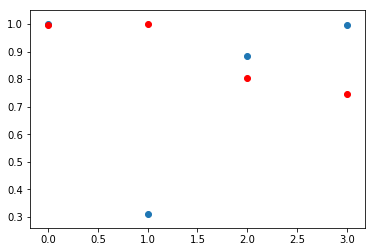

In [658]:
x = list(range(len(my_out)))
plt.scatter(x, my_out)
plt.scatter(x, out, color='r')
plt.show()


In [659]:
X.values.dot(theta)

array([[ 8.43112183],
       [-0.79662371],
       [ 2.03281522],
       [ 5.78950548]], dtype=float32)

In [660]:
out == my_out

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]], dtype=bool)

In [569]:
# ok now let's check the gradient stuff
def grad(X, theta, y):
    diff = y - sig(X, theta)
    g = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j  in range(X.shape[1]):
            g[i,j] = diff[i] * X[i,j]
    return g

In [570]:
y

0    1.0
1    0.0
Name: y, dtype: float32

In [571]:
grad(X.values, theta, y.values), sig(X.values, theta), y.values

(array([[ 0.09826134, -0.01163261],
        [-1.70264673,  2.22991967]]),
 array([ 0.99072778,  0.28180367], dtype=float32),
 array([ 1.,  0.], dtype=float32))

In [610]:
gradient = np.zeros(shape=X.shape, dtype=np.float32)


In [611]:
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
grad_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR , hostbuf=gradient)

In [612]:
grad_event = programs.logistic_gradient_ols(queue,
                                            X.shape,
                                            None,
                                            X_buf,
                                            theta_buf,
                                            y_buf,
                                            grad_buf,
                                            nrows,
                                            ncols)

In [613]:
gradient

array([[ 0.,  0.],
       [ 0.,  0.]], dtype=float32)

In [614]:
grad_event.wait()

In [615]:
pcl.enqueue_copy(queue, gradient, grad_buf).wait()

In [619]:
gradient.T == grad(X.values, theta, y.values)

array([[ True,  True],
       [ True,  True]], dtype=bool)

In [617]:
gradient

array([[ 0.09826134, -1.70264673],
       [-0.01163261,  2.22991967]], dtype=float32)

In [618]:
grad(X.values, theta, y.values).

array([[ 0.09826134, -0.01163261],
       [-1.70264673,  2.22991967]])